# Approximate-Nearest-Neighbors Image Search Pipeline

This notebook details a pipeline for performing approximate nearest neighbors search on a dataset of images by tokenizing the images into vectors using a pre-trained model. The Faiss library is then used for approximate nearest neighbors search. The metric used for the search is euclidean distance.

In [53]:
import os
from PIL import Image
import torch
from torch import nn, optim
from torchvision import transforms
from transformers import CLIPModel, CLIPProcessor
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import faiss
import time
from collections import defaultdict
from typing import Tuple, Dict, List
from matplotlib import pyplot as plt

## Data

### Load Sampled Dataset

In [2]:
# Set up the folder paths
dataset_path = "datasets/house_styles"
image_folder = "datasets/house_styles/all_images"

sampled_images = pd.read_csv(os.path.join(dataset_path, "sampled_labels.csv"))
sampled_image_names = sampled_images["file_label"].values

,file_label,house_type
0,350_ff091a99.jpg,farmhouse
1,258_560ea146.jpg,farmhouse
2,001_d2c7428a.jpg,farmhouse
3,131_1251d4eb.jpg,farmhouse
4,447_96c74801.jpg,farmhouse


### Select Query Images

In [24]:
# Paired data
pairs_path = os.path.join(dataset_path, "sampled_paired_labels_shuffled.csv")
pairs_df = pd.read_csv(pairs_path)

# count labeled pairs:
tagged_pairs = pairs_df["similarity"].value_counts()
print("Total number of pairs: ", len(pairs_df))
print("Number of labeled pairs: ", tagged_pairs.sum())

Total number of pairs:  101042
Number of labeled pairs:  68093


Text(0.5, 1.0, 'Distribution of pair counts')

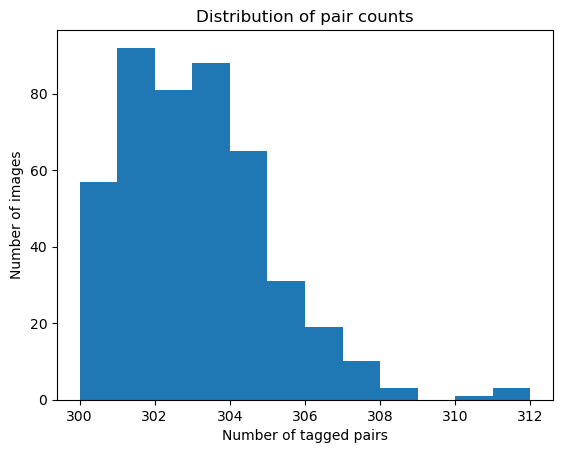

In [44]:
# Count pairs and build relevance judgments in a single pass
pair_counts = defaultdict(int)
relevance_judgments = defaultdict(dict)

# Create temporary lookup array for better performance
pairs_array = pairs_df[['image1', 'image2', 'similarity']].values

for img1, img2, sim in pairs_array:
    if sim in [0,1,2,3]:
        # Update counts
        pair_counts[img1] += 1
        pair_counts[img2] += 1
        
        # Store relevance judgments (both directions)
        relevance_judgments[img1][img2] = sim
        relevance_judgments[img2][img1] = sim

sorted_images_by_count = sorted(pair_counts.items(), key=lambda x: x[1], reverse=True)
# print("Images with the most tagged pairs:")
# for img, count in sorted_images_by_count[:50]:
#     print(f"{img}: {count}")

# distribution of pair counts:
pair_counts_values = list(pair_counts.values())
plt.hist(pair_counts_values, bins=12)
plt.xlabel("Number of tagged pairs")
plt.ylabel("Number of images")
plt.title("Distribution of pair counts")


In [47]:
n_queries = 50
queries = sorted_images_by_count[:n_queries]
print("lowest pair count: ", queries[-1][1])

lowest pair count:  305


This means that the query images have at least 5 images labeled manually. 

In [46]:
query_image_names = [img for img, _ in queries]
index_image_names = [img for img, _ in sorted_images_by_count[n_queries:]]

print("Number of queries: ", len(query_image_names))
print("Number of index images: ", len(index_image_names))

Number of queries:  50
Number of index images:  400


## Embedding Models

In [58]:
# Set up device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cpu


### Load Computer Vision Model

In [72]:
# Load the pretrained CLIP model and processor from Hugging Face
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Set up the image transformation pipeline
clip_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])


/Users/naomi/miniconda3/envs/Lab2_env/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### Load Fine-Tuned Model

In [63]:
class SiameseNetworkEmbedder(nn.Module):
    def __init__(self):
        super(SiameseNetworkEmbedder, self).__init__()
        self.fc1 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.relu = nn.ReLU()

    def forward_one(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc3(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        return output1, output2
    
    def get_embedding(self, x):
        return self.forward_one(x)

siamese_model = SiameseNetworkEmbedder()
siamese_model.load_state_dict(torch.load("active_learning_models/net_round4.pth", map_location=torch.device(device)))

<All keys matched successfully>

## Embed Images

In [91]:
# Function to load and preprocess an image
def load_and_preprocess_image(image_path):
    try:
        image = Image.open(image_path).convert("RGB")
        return clip_transform(image)
    except Exception as e:
        raise IOError(f"Error loading image '{image_path}': {e}")

# Function to tokenize and get vector representation of an image
def get_image_vector_clip(image_tensor):
    image_tensor = image_tensor.unsqueeze(0)
    inputs = clip_processor(images=image_tensor, return_tensors="pt")
    with torch.no_grad():
        image_features = clip_model.get_image_features(**inputs)
    return image_features.cpu().numpy().flatten()

def get_image_vector_siamese(image_tensor):
    image_tensor = image_tensor.unsqueeze(0)
    inputs = clip_processor(images=image_tensor, return_tensors="pt")
    with torch.no_grad():
        image_features = clip_model.get_image_features(**inputs)
    images_features = image_features.squeeze()

    image_emb = siamese_model.get_embedding(images_features.to(device))
    image_emb = image_emb.cpu().detach().numpy()
    return image_emb

def save_image_vectors(image_names, output_file_path):
    clip_vectors_list = []
    siamese_vectors_list = []

    for image_name in tqdm(image_names):
        image_path = os.path.join(image_folder, image_name)

        # try:
        image_tensor = load_and_preprocess_image(image_path)
        image_vector_clip = get_image_vector_clip(image_tensor)
        image_vector_siamese = get_image_vector_siamese(image_tensor)

        clip_vectors_list.append(image_vector_clip)
        siamese_vectors_list.append(image_vector_siamese)

        # except Exception as e:
        #     print(f"Error processing image '{image_path}': {e}")

    clip_vectors = np.stack(clip_vectors_list)
    siamese_vectors = np.stack(siamese_vectors_list)
    
    np.save(output_file_path + "_clip.npy", clip_vectors)
    np.save(output_file_path + "_siamese.npy", siamese_vectors)
    
    return clip_vectors, siamese_vectors

In [92]:
output_path = "vector_dbs/house_styles/"

if os.path.exists(output_path):
    print("Output path already exists.")
else:
    query_vectors_clip, query_vectors_siamese = save_image_vectors(query_image_names, output_path + "vectors_query")
    print(f"{len(query_vectors_clip)} clip image vectors saved, {len(query_vectors_siamese)} siamese image vectors saved.")

    index_vectors_clip, index_vectors_siamese = save_image_vectors(index_image_names, output_path + "vectors_index")
    print(f"{len(index_vectors_clip)} clip image vectors saved, {len(index_vectors_siamese)} siamese image vectors saved.")

100%|██████████| 50/50 [01:10<00:00,  1.41s/it]


50 clip image vectors saved, 50 siamese image vectors saved.


100%|██████████| 400/400 [08:13<00:00,  1.23s/it]

400 clip image vectors saved, 400 siamese image vectors saved.


### Load Tokenized Images

In [4]:
output_path = "vector_dbs/house_styles/"

index_vectors_clip = np.load(output_path + "vectors_index_clip.npy")
query_vectors_clip = np.load(output_path + "vectors_query_clip.npy")
index_vectors_siamese = np.load(output_path + "vectors_index_siamese.npy")
query_vectors_siamese = np.load(output_path + "vectors_query_siamese.npy")

print(f"Loaded {len(index_vectors_clip)} index image vectors and {len(query_vectors_clip)} query image vectors.")
print(f"Loaded {len(index_vectors_siamese)} index image vectors and {len(query_vectors_siamese)} query image vectors.")

Loaded 693 index vectors and 174 query vectors.


## Ground Truth

In [93]:
# def semi_optimized_exhaustive_search(
#         index_vectors: np.ndarray,
#         query_vectors: np.ndarray,
#         k: int,
# ):
#     """
#     This function performs an optimized exhaustive search.
#     Args:
#         index_vectors: An array of shape (n_index, dim) containing the index vectors.
#         query_vectors: An array of shape (n_queries, dim) containing the query vectors. 
#         dim: The dimensionality of the vectors.
#     Returns:
#         An array of shape (n_queries, k) containing the indices of the k nearest neighbors for each query vector.
#     """
#     ann_lists = []
#     for query_vec in tqdm(query_vectors):
#         # distances = np.linalg.norm(index_vectors - query_vec, axis=1)
#         distances = np.dot(index_vectors, query_vec)
#         ann_lists.append(list(np.argsort(distances)[:k]))
#     return np.array(ann_lists)

def compute_recall_at_k(
        nn_gt: np.ndarray,
        ann: np.ndarray,
        k: int,
):
    """
    This function computes the recall@k.
    Args:
        nn_gt: The ground truth nearest neighbors.
        ann: The approximate nearest neighbors.
        k: The number of nearest neighbors to consider.
    Returns:
        The recall@k.
    """
    return round(sum([len(set(ann[i]) & set(nn_gt[i])) / k for i in range(len(ann))])/len(ann), 3)

## Faiss Index

### Build Index

In [111]:
def build_faiss_lsh_index(
        index_vectors: np.ndarray,
        dim: int,
        nbits: int,
):
    """
    This function builds a Faiss LSH index.
    Args:
        index_vectors: An array of shape (n_index, dim) containing the index vectors.
        dim: The dimensionality of the vectors. 
        nbits: The number of bits to use in the hash.
    Returns:
        A Faiss LSH index.
    """
    index = faiss.IndexLSH(dim, nbits)
    index.add(index_vectors)
    return index

def build_faiss_flatl2_index(
        index_vectors: np.ndarray,
        dim: int,
):
    """
    This function builds a Faiss flat L2 index.
    Args:
        index_vectors: An array of shape (n_index, dim) containing the index vectors.
        dim: The dimensionality of the vectors. 
    Returns:
        A Faiss flat L2 index.
    """
    np.random.seed(42)
    num_vectors = index_vectors.shape[0]
    dim = index_vectors.shape[1]
    norm_index_vectors = index_vectors / np.linalg.norm(index_vectors, axis=1, keepdims=True)

    index = faiss.IndexFlatL2(dim)
    index.add(norm_index_vectors)
    return index

def build_faiss_hnsw_index(
        index_vectors: np.ndarray,
        dim: int,
        nlinks: int,
):
    """
    This function builds a Faiss HNSW index.
    Args:
        index_vectors: An array of shape (n_index, dim) containing the index vectors.
        dim: The dimensionality of the vectors. 
        nlinks: The number of links to use in the graph.
    Returns:
        A Faiss HNSW index.
    """
    index = faiss.IndexHNSWFlat(dim, nlinks, faiss.METRIC_L2)
    index.add(index_vectors)
    return index

def faiss_search(
        query_vectors: np.ndarray,
        index: faiss.Index,
        k: int,
):
    """
    This function uses a Faiss index to search for the k-nearest neighbors of query_vectors.
    Args:
        query_vectors: An array of shape (n_queries, dim) containing the query vectors. 
        index: A Faiss index.
        k: The number of nearest neighbors to retrieve.
    Returns:
        An array of shape (, ) containing the indices of the k-nearest neighbors for each query vector.
    """
    if not isinstance(index, faiss.Index):
        raise ValueError("The index must be a Faiss index.")
    if isinstance(index, faiss.IndexFlatL2):
        num_queries = query_vectors.shape[0]
        dim = query_vectors.shape[1]
        query_vectors = query_vectors / np.linalg.norm(query_vectors, axis=1, keepdims=True)

    distances, indices = index.search(query_vectors, k)
    return indices

In [96]:
k=10
dim = index_vectors_clip.shape[1]

In [98]:
%%time
faiss_lsh_index = build_faiss_lsh_index(index_vectors_clip, dim, nbits=100)

CPU times: user 14 ms, sys: 18.4 ms, total: 32.4 ms
Wall time: 12 ms


In [99]:
%%time
faiss_l2_index = build_faiss_flatl2_index(index_vectors_clip, dim)

CPU times: user 1.02 ms, sys: 1.78 ms, total: 2.8 ms
Wall time: 4.96 ms


In [112]:
%%time
faiss_hnsw_index = build_faiss_hnsw_index(index_vectors_clip, dim, nlinks=16)

CPU times: user 17.2 ms, sys: 5.42 ms, total: 22.6 ms
Wall time: 6.56 ms


### Compare Index Recall Compared to Exact Search

In [102]:
%%time
faiss_l2_ann = faiss_search(query_vectors_clip, faiss_l2_index, k)

CPU times: user 2.23 ms, sys: 2.49 ms, total: 4.72 ms
Wall time: 1.81 ms


In [103]:
%%time
faiss_lsh_ann = faiss_search(query_vectors_clip, faiss_lsh_index, k)

print(f"recall@10 for faiss_lsh_index: {compute_recall_at_k(faiss_l2_ann, faiss_lsh_ann, k)}")

recall@10 for faiss_lsh_index: 0.09
CPU times: user 2.17 ms, sys: 1.45 ms, total: 3.62 ms
Wall time: 4.66 ms


In [113]:
%%time
faiss_hnsw_ann = faiss_search(query_vectors_clip, faiss_l2_index, k)

print(f"recall@10 for faiss_l2_index: {compute_recall_at_k(faiss_l2_ann, faiss_hnsw_ann, k)}")

recall@10 for faiss_l2_index: 1.0
CPU times: user 2.28 ms, sys: 3.25 ms, total: 5.53 ms
Wall time: 3.69 ms


### Conclusions

For vectors resulting from CLIP embeddings, we see the best performance in ANN compared to exact search in the -- Index. With a recall of --.

We will use this index in the rest of out work and analysis.

## NMSLIB Index

In [1]:
%conda install -c conda-forge nmslib

Channels:
 - conda-forge
 - defaults
Platform: osx-arm64
Solving environment: done

## Package Plan ##

  environment location: /Users/naomi/miniconda3/envs/Lab2_env

  added / updated specs:
    - nmslib


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2024.8.30  |       hf0a4a13_0         155 KB  conda-forge
    certifi-2024.7.4           |     pyhd8ed1ab_0         156 KB  conda-forge
    nmslib-2.1.1               |  py310hb6aeb05_0         592 KB
    pybind11-2.13.5            |  py310h7306fd8_0         189 KB  conda-forge
    pybind11-global-2.13.5     |  py310h7306fd8_0         177 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         1.2 MB

The following NEW packages will be INSTALLED:

  nmslib             pkgs/main/osx-arm64::nmslib-2.1.1-py310hb6aeb05_0 
  pybind11           c

In [15]:
import nmslib

# Example data
data = np.random.random((1000, 128)).astype(np.float32)

# Create an index using a custom distance function
def custom_distance(vec1, vec2):
    return np.sum(np.abs(vec1 - vec2))  # Example: Manhattan distance

index = nmslib.init(method='hnsw', space='cosinesimil')
index.addDataPointBatch(data)
index.createIndex({'post': 2}, print_progress=True)

# Query
ids, distances = index.knnQuery(data[0], k=10)



0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

## PyNNDescent Index

In [ ]:
### run this in Lab2_env:
# conda install -c conda-forge pynndescent

In [5]:
import pynndescent
from numba import njit

In [6]:
### Define a unique distance function and compile it with Numba:
@njit
def custom_distance(x, y):
    return np.sum(np.abs(x - y))

In [8]:
index = pynndescent.NNDescent(index_vectors, metric=custom_distance)

In [9]:
indices, distances = index.query(query_vectors, k=5)

### Experiments with Cosine Similarity

In [35]:
k=20

In [41]:
### Exhaustive Search - Comparative Baseline ###
start = time.time()
gt_nn = semi_optimized_exhaustive_search(index_vectors, query_vectors, k)
end = time.time()
print(f"Exhaustive search time: {end - start:.2f} seconds")

100%|██████████| 174/174 [00:00<00:00, 4104.34it/s]

Exhaustive search time: 0.04 seconds


In [37]:
start = time.time()
nndescent_index = pynndescent.NNDescent(index_vectors, metric='dot')
end = time.time()
print(f"Indexing time: {end - start:.2f} seconds")

Indexing time: 0.30 seconds


In [38]:
start = time.time()
indices, distances = nndescent_index.query(query_vectors, k)
end = time.time()
print(f"Query time: {end - start:.2f} seconds")

Query time: 0.88 seconds


In [42]:
recall = compute_recall_at_k(gt_nn, indices, k)
print(f"recall@{k} for pynndescent: {recall}")

recall@20 for pynndescent: 0.02
